In [40]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

%matplotlib inline

In [2]:
dataset_dir = '/mnt/d/DataSets/whiteboard/'
data_yaml = dataset_dir + '/data.yaml'

In [15]:
model = YOLO("yolov8s-seg.pt")

In [13]:
results = model.train(
    data=str(data_yaml),
    task="segment",
    epochs=15,
    imgsz=960,
    batch=6,
    device="cuda",
    workers=6,
    cache=True,
    amp=True,
    patience=5,
    name="whiteboard_seg_45960"
)

print(f'Обучение завершено. Путь сохранения: {results.save_dir}')

New https://pypi.org/project/ultralytics/8.3.241 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.240 🚀 Python-3.12.3 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/mnt/d/DataSets/whiteboard//data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/segment/whiteboard_seg_30960/weights/best.pt, momentum=0.937, mo

In [3]:
weights = 'runs/segment/whiteboard_seg_20640/weights/best.pt' 
model = YOLO(str(weights))

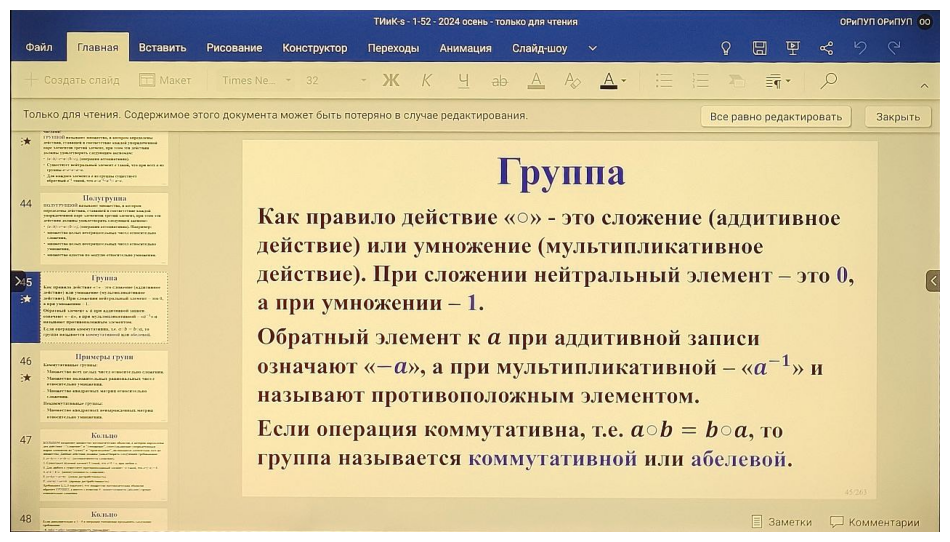

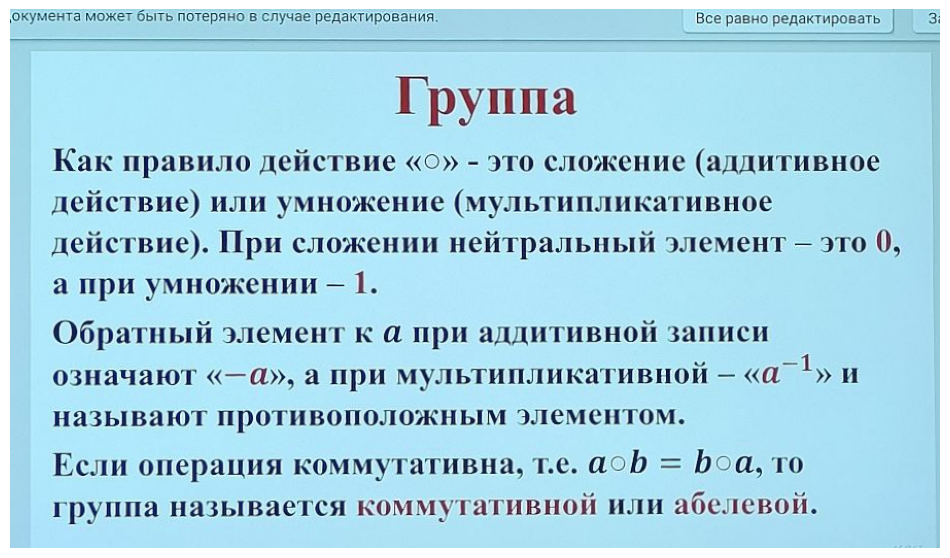

In [36]:
def find_and_fix_perspective(img, target_class=None, target_strategy='conf'): 
    pred = model.predict(
        source=img,
        conf=0.25,
        iou=0.5,
        device="cuda",
        save=False,
        verbose=False
    )[0]

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]

    boxes = pred.boxes
    boxes_count = boxes.cls.cpu().numpy().shape[0]
    idxs = np.arange(boxes_count, dtype=int)
    
    classes = boxes.cls.cpu().numpy()
    if target_class != None:
        idxs = (classes == target_class).nonzero()[0]

    if len(idxs) >= 2: 
        if target_strategy == 'conf': 
            idxs = idxs[boxes.conf[idxs].argmax()]
        elif target_strategy == 'size': 
            xywh = boxes.xywh.cpu().numpy()
            sizes = xywh[:, 2] * xywh[:, 3]
            idxs = int(idxs[np.argmax(sizes[idxs])])

    mask = pred.masks.data[idxs].detach().cpu().numpy()
    if mask.ndim == 3:
        mask = mask[0]
    mask = cv2.resize(mask, (W, H), cv2.INTER_NEAREST)
    mask = (mask > 0.5).astype(np.uint8) * 255

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key=cv2.contourArea) # контур маски
    
    # получение 4 углов аппроксимацией
    peri = cv2.arcLength(cnt, True)
    quad = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    
    if len(quad) == 4:
        box = quad.reshape(4, 2)
    else:
        # если не вышло аппроксимацией
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
    
    box = box.astype(int) # четырехугольник

    poly_mask = np.zeros((H, W), dtype=np.uint8)
    cv2.fillPoly(poly_mask, [box.astype(np.int32)], 255)
    crop_poly = cv2.bitwise_and(img_rgb, img_rgb, mask=poly_mask)
    
    
    pts = box.astype(np.float32)
    s = pts.sum(1); d = np.diff(pts, axis=1).ravel()
    tl = pts[np.argmin(s)]; br = pts[np.argmax(s)]
    tr = pts[np.argmin(d)]; bl = pts[np.argmax(d)]
    src = np.array([tl, tr, br, bl], np.float32)
    
    w = int(max(np.linalg.norm(br-bl), np.linalg.norm(tr-tl)))
    h = int(max(np.linalg.norm(tr-br), np.linalg.norm(tl-bl))) 
    
    dst = np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]], np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    warp = cv2.warpPerspective(img_rgb, M, (w, h))

    return warp
    

test_path = 'tests/аса.jpg'
test_img = cv2.imread(test_path)
plt.figure(figsize=(12, 7))
plt.imshow(test_img)
plt.axis('off')
plt.show()

res = find_and_fix_perspective(test_img)
plt.figure(figsize=(12, 7))
plt.imshow(res)
plt.axis('off')
plt.show()

In [47]:
in_dir = '/mnt/d/DataSets/whiteboard_imgs/'
out_dir = '/mnt/d/DataSets/warped_whiteboard/'

paths = glob.glob(os.path.join(in_dir, '*'))

for img_path in paths:
    img = cv2.imread(img_path, cv2.IMREAD_COLOR_BGR)
    try:
        warp = find_and_fix_perspective(img)
        warp_rgb = cv2.cvtColor(warp, cv2.COLOR_BGR2RGB)
        filename = os.path.basename(img_path)
        cv2.imwrite(f'{out_dir}{filename}', warp_rgb)
        print(f'Done: {filename}')
    except Exception as e:
        print(f'ERROR: {filename}')

Done: -1cdVmYa6r-BazF8mjqvyh9h3ebMYfxC6Tr8HTGrHJmqAychQrscz_peK5nTGlCMypDf1SvNrjouhBTzrcxm6epG.jpg
Done: 1tDIQgk2mEC3a1G63sVaqkViS8tOUyWj4472pk6nm87DdMO7FaomPTGoRjQ31avlTDy38-4YNAEjQ84U722Yn8fl.jpg
Done: 1TwhmR8NPP0MStfVr0mUseKL4EbXttowj58yn3nxdXzzhBQAlW8XAzO6FEHcSjxXLlj_tuUlSMtG_Y3X2Z54TLP7.jpg
Done: 2024-02-10 09-50-44.JPG
Done: 2024-02-10 09-54-13.JPG
Done: 2024-02-10 09-58-34.JPG
Done: 2024-02-10 13-25-22.JPG
Done: 2024-02-10 13-56-49.JPG
Done: 2024-02-10 14-13-05.JPG
Done: 2024-02-10 14-17-29.JPG
Done: 2024-02-10 14-19-25.JPG
Done: 2024-02-10 14-22-14.JPG
Done: 2024-02-10 14-26-17.JPG
Done: 2024-02-12 10-00-14 (1).JPG
Done: 2024-02-12 10-03-39.JPG
Done: 2024-02-12 10-04-08.JPG
Done: 2024-02-12 14-42-28 (1).JPG
Done: 2BVln6tPY5IAm74tPcwmqw2wjBPgocMxdSTr16ZoEi1VCp3DQDSaoG6Obueu6UyaYt-J-_t108S23RS_pfc75Zec.jpg
Done: 3QAZx4cO4SMjnUJP3FLtUH1rZ_KDvaI7Qjif3zwNS4lUoPOF2PW8SLr8Q_yw0qolRUHFBWjhAQHsxcbFga35yJc5.jpg
Done: 40zJHZWeJxh2WtG6lUbMKKY-PyyZnhYsbcrkS_IrODdAgIrcMQsnORg7nYx9QzjC3EBt7p0